# Mapping Using Doc2Vec Embedding and PCA
---------------
``` 

Contributors: 
- Elias Gabriel Heppner


***

This script implements the speech mapping using doc2vec embedding and pca. It closely follows the approach first developed by Rheault and Cochrane (2019) https://www.cambridge.org/core/journals/political-analysis/article/abs/word-embeddings-for-the-analysis-of-ideological-placement-in-parliamentary-corpora/017F0CEA9B3DB6E1B94AC36A509A8A7B

## Loading Packages


In [1]:
import numpy as np 
import pandas as pd 
import time
import pickle
import time
import os
import csv
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Speeches Data


In [2]:
#Define 
os.chdir("../data/opendiscourse")
os.getcwd()



'c:\\Users\\elias\\Documents\\Master\\3. Semester\\LLM\\final_project\\Politricks\\data\\opendiscourse'

In [3]:
ukraine_speeches = pd.read_pickle('ukraine_war_speeches.pkl')
migration_speeches = pd.read_pickle('migration_speeches.pkl')
covid_speeches = pd.read_pickle('covid_speeches.pkl')
all_speeches = pd.read_pickle('parliament_speeches.pkl')

print(len(ukraine_speeches))
print(len(migration_speeches))
print(len(covid_speeches))

migration_speeches
#all fine


3094
4247
2913


,id_x,session,electoral_term,date,document_url,speech_content,politician_id,first_name,last_name,faction_id,abbreviation,position_short,position_long,speech_tokenized,tokenized_length
41,1004092,20,19,2018-03-15,https://dip21.bundestag.de/dip21/btp/19/19020.pdf,\n\nHerr Präsident! Meine Damen und Herren! De...,11003848,Petra,Sitte,6,DIE LINKE.,Member of Parliament,NA,"[Herr, Präsident, !, Meine, Damen, und, Herren...",606
46,1011769,49,19,2018-09-13,https://dip21.bundestag.de/dip21/btp/19/19049.pdf,\n\nFrau Präsidentin! Meine Damen und Herren! ...,11003848,Petra,Sitte,6,DIE LINKE.,Member of Parliament,NA,"[Frau, Präsidentin, !, Meine, Damen, und, Herr...",965
86,1058131,220,19,2021-04-13,https://dip21.bundestag.de/dip21/btp/19/19220.pdf,\n\nFrau Präsidentin! Meine Damen und Herren! ...,11003848,Petra,Sitte,6,DIE LINKE.,Member of Parliament,NA,"[Frau, Präsidentin, !, Meine, Damen, und, Herr...",451
92,1063302,236,19,2021-06-24,https://dip21.bundestag.de/dip21/btp/19/19236.pdf,\n\nFrau Präsidentin! Meine Damen und Herren! ...,11003848,Petra,Sitte,6,DIE LINKE.,Member of Parliament,NA,"[Frau, Präsidentin, !, Meine, Damen, und, Herr...",823
102,797271,17,18,2014-02-20,https://dip21.bundestag.de/dip21/btp/18/18017.pdf,Herr Präsident! Liebe Kolleginnen und Kollegen...,11003206,Petra,Pau,6,DIE LINKE.,Member of Parliament,NA,"[Herr, Präsident, !, Liebe, Kolleginnen, und, ...",933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36858,1069509,27,20,2022-04-06,https://dip21.bundestag.de/dip21/btp/20/20027.pdf,\n\nFrau Präsidentin! Werte Kollegen! Meine Da...,11005264,Joachim,Wundrak,0,AfD,Member of Parliament,NA,"[Frau, Präsidentin, !, Werte, Kollegen, !, Mei...",927
36859,1069865,28,20,2022-04-07,https://dip21.bundestag.de/dip21/btp/20/20028.pdf,\n\nFrau Präsidentin! Werte Kollegen! Meine Da...,11005264,Joachim,Wundrak,0,AfD,Member of Parliament,NA,"[Frau, Präsidentin, !, Werte, Kollegen, !, Mei...",558
36865,1067399,18,20,2022-02-18,https://dip21.bundestag.de/dip21/btp/20/20018.pdf,\n\nFrau Präsidentin! Meine sehr verehrten Dam...,11005099,Malte,Kaufmann,0,AfD,Member of Parliament,NA,"[Frau, Präsidentin, !, Meine, sehr, verehrten,...",427
36882,1066506,15,20,2022-04-07,https://dip21.bundestag.de/dip21/btp/20/20015.pdf,\n\nFrau Präsidentin! Meine Damen und Herren! ...,11005157,Matthias,Moosdorf,0,AfD,Member of Parliament,NA,"[Frau, Präsidentin, !, Meine, Damen, und, Herr...",749


### Preprocess Speech Data


In [5]:
#find party where missing, if possible
def replace_abbreviations(df):
    df.reset_index(drop=True, inplace=True)
    for i in range(len(df)):        
        if df.loc[i, 'abbreviation'] == 'not found':
            last_name = df.loc[i, 'last_name']
            first_name = df.loc[i, 'first_name']
    
            correct_abbreviations_df = df[(df['abbreviation'] != 'not found') & (df['last_name'] == last_name) & (df['first_name'] == first_name)]

            try:
                correct_abbreviation = correct_abbreviations_df['abbreviation'].mode()[0] # uses the mode (if someone has two 'parties' (eg. fraktionslos & AfD))
                correct_id = correct_abbreviations_df['faction_id'].mode()[0]
            except:
                correct_abbreviation = None
                correct_id = -1            
    
            df.loc[i, 'abbreviation'] = correct_abbreviation
            df.loc[i, 'faction_id'] = correct_id
            
    print('Unfound abbreviations:', len(df[df['abbreviation'] == None]))
        
        #If still not found, drop
    df.drop(df[df['abbreviation'].isna()].index, inplace=True)
    #df.reset_index(drop=True, inplace=True)

In [6]:
#get whether person was in government or not
def get_govop(df):
    df["gov_op"] = None
    check_groko = (df['electoral_term'] == 18) | (df['electoral_term'] == 19)

    # Assign 1 to 'gov_op' where the electoral term is 18 or 19 and the party is CDU/CSU or SPD
    df.loc[check_groko & (df['abbreviation'].isin(['CDU/CSU', 'SPD'])), 'gov_op'] = 1
    # Assign 0 to 'gov_op' where the electoral term is 18 or 19 and the party is not CDU/CSU or SPD
    df.loc[check_groko & ~(df['abbreviation'].isin(['CDU/CSU', 'SPD'])), 'gov_op'] = 0
    
    check_ampel = df['electoral_term'] == 20
    
    df.loc[check_ampel & df['abbreviation'].isin(['FDP', 'Grüne', 'SPD']), 'gov_op'] = 1
     # Assign 0 to 'gov_op' where the electoral term is 18 or 19 and the party is not CDU/CSU or SPD
    df.loc[check_ampel & ~(df['abbreviation'].isin(['FDP', 'Grüne', 'SPD'])), 'gov_op'] = 0
                
    return df


In [7]:
#get full name for comparison to generated speeches
def get_fullname(df):
    df["full_name"] = df.apply(lambda row: row["first_name"] + ' ' + row["last_name"], axis=1)
    return df

In [8]:
##Apply
ukraine_speeches["abbreviation"] = ukraine_speeches["abbreviation"].replace("DIE LINKE.", "DIE LINKE")#replace to align with artificial speeches
migration_speeches["abbreviation"] = migration_speeches["abbreviation"].replace("DIE LINKE.", "DIE LINKE")
covid_speeches["abbreviation"] = covid_speeches["abbreviation"].replace("DIE LINKE.", "DIE LINKE")

for i,j in zip([ukraine_speeches, migration_speeches, covid_speeches], ['n_ukraine_speeches', 'n_migration_speeches', 'n_covid_speeches']):
    replace_abbreviations(i)
    
ukraine_speeches = get_fullname(ukraine_speeches)
covid_speeches = get_fullname(covid_speeches)
migration_speeches = get_fullname(migration_speeches)

ukraine_speeches = get_govop(ukraine_speeches)
covid_speeches = get_govop(covid_speeches)
migration_speeches = get_govop(migration_speeches)

Unfound abbreviations: 0
Unfound abbreviations: 0
Unfound abbreviations: 0


In [9]:
print(len(ukraine_speeches))
print(len(migration_speeches))
print(len(covid_speeches))

2902
4024
2749


## Load LLM Generated Speeches

In [ ]:
politicians = [{'name' : 'Alexander Gauland', 'party' : 'AfD'},
               {'name' : 'Peter Boehringer', 'party' : 'AfD'},
               {'name' : 'Norbert Kleinwächter', 'party' : 'AfD'},
               {'name' : 'Götz Frömming', 'party' : 'AfD'},
               {'name' : 'Rolf Mützenich', 'party' : 'SPD'},
               {'name' : 'Helge Lindh', 'party' : 'SPD'},
               {'name' : 'Karl Heinz Brunner', 'party' : 'SPD'},
               {'name' : 'Daniela De Ridder', 'party' : 'SPD'},
               {'name' : 'Thorsten Frei', 'party' : 'CDU/CSU'},
               {'name' : 'Alexander Dobrindt', 'party' : 'CDU/CSU'},
               {'name' : 'Philipp Amthor', 'party' : 'CDU/CSU'},
               {'name' : 'Andrea Lindholz', 'party' : 'CDU/CSU'},
               {'name' : 'Thomas Hacker', 'party' : 'FDP'},
               {'name' : 'Christian Lindner', 'party' : 'FDP'},
               {'name' : 'Konstantin Kuhle', 'party' : 'FDP'},
               {'name' : 'Stephan Thomae', 'party' : 'FDP'},
               {'name' : 'Dietmar Bartsch', 'party' : 'DIE LINKE'},
               {'name' : 'Gesine Lötzsch', 'party' : 'DIE LINKE'},
               {'name' : 'Kathrin Vogler', 'party' : 'DIE LINKE'},
               {'name' : 'Heike Hänsel', 'party' : 'DIE LINKE'},
               {'name' : 'Katrin Dagmar Göring-Eckardt', 'party' : 'Grüne'},
               {'name' : 'Annalena Baerbock', 'party' : 'Grüne'},
               {'name' : 'Anton Hofreiter', 'party' : 'Grüne'},
               {'name' : 'Omid Nouripour', 'party' : 'Grüne'}]

politician_df = pd.DataFrame(politicians)
pol_names = politician_df['name'].tolist()


In [11]:
os.chdir("../gpt_output")
import json

with open("llm_speeches_party.json", "r") as file:
    sp_party = json.load(file)

with open("llm_speeches_pol.json", "r") as file:
    sp_pol = json.load(file)
    
with open("llm_speeches_pol_party.json", "r") as file:
    sp_pol_party = json.load(file)

In [12]:
#turn to df

# Extract data for each row
def conv_dict(llm_dict, doc_type, pol = None):
    
    party_list = []
    name_list = []
    topic_list = []
    content_list = []
    for entry in llm_dict:
        party = entry['party']
        if pol == "pol":
            name = entry['name']
        llm_output = entry['llm_output']
        for topic, content in llm_output.items():
            for item in content:
                party_list.append(party)
                topic_list.append(topic)
                content_list.append(item)
                if pol == "pol":
                    name_list.append(name)

    # Create DataFrame
    dict_df = pd.DataFrame({
        'speech_content': content_list,
        'abbreviation': party_list,
        "full_name": None,
        'topic': topic_list
    })
            
    if pol == "pol":
        dict_df = pd.DataFrame({
        'speech_content': content_list,
        'abbreviation': party_list,
        "full_name": name_list,
        'topic': topic_list
        })
               
    #assume current government as this is what LLM will do
    dict_df["gov_op"] = None
    dict_df.loc[dict_df['abbreviation'].isin(['FDP', 'Grüne', 'SPD']), 'gov_op'] = 1
    dict_df.loc[~(dict_df['abbreviation'].isin(['FDP', 'Grüne', 'SPD'])), 'gov_op'] = 0
        
    dict_df["doc_type"] = doc_type
    
    return dict_df



In [13]:
#Apply conversion
llm_part_df = conv_dict(sp_party, "llm_party")# covid_speeches_pols
llm_part_df

,speech_content,abbreviation,full_name,topic,gov_op,doc_type
0,"Sehr geehrte Frau Präsidentin, verehrte Kolleg...",AfD,None,Ukraine-Krieg,0,llm_party
1,"Sehr geehrte Frau Präsidentin, verehrte Kolleg...",AfD,None,Ukraine-Krieg,0,llm_party
2,"Sehr geehrter Herr Präsident, verehrte Kollege...",AfD,None,Ukraine-Krieg,0,llm_party
3,"Sehr geehrte Damen und Herren, verehrte Kolleg...",AfD,None,Ukraine-Krieg,0,llm_party
4,"Meine sehr geehrten Damen und Herren,wir stehe...",AfD,None,Covid-19,0,llm_party
...,...,...,...,...,...,...
67,"Sehr geehrter Herr Bundestagspräsident, sehr g...",Grüne,None,Covid-19,1,llm_party
68,"Sehr geehrte Damen und Herren, verehrte Kolleg...",Grüne,None,Migration,1,llm_party
69,"Sehr geehrte Damen und Herren, sehr geehrter H...",Grüne,None,Migration,1,llm_party
70,"Sehr geehrte Frau Präsidentin, sehr geehrte Mi...",Grüne,None,Migration,1,llm_party


In [14]:
#Apply conversion
llm_pol_df = conv_dict(sp_pol, "llm_pol", "pol")
llm_pol_df

,speech_content,abbreviation,full_name,topic,gov_op,doc_type
0,"Sehr geehrter Herr Präsident, verehrte Kollegi...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol
1,"Sehr geehrte Frau Präsidentin, verehrte Kolleg...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol
2,"Sehr geehrte Damen und Herren,wir stehen heute...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol
3,"Meine sehr geehrten Damen und Herren,wir stehe...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol
4,"Sehr geehrte Frau Präsidentin, sehr geehrte Da...",AfD,Alexander Gauland,Covid-19,0,llm_pol
...,...,...,...,...,...,...
283,"Sehr geehrte Damen und Herren,verehrte Mitglie...",Grüne,Omid Nouripour,Covid-19,1,llm_pol
284,"Sehr geehrte Frau Präsidentin,sehr geehrter He...",Grüne,Omid Nouripour,Migration,1,llm_pol
285,"Sehr geehrter Herr Bundestagspräsident,sehr ge...",Grüne,Omid Nouripour,Migration,1,llm_pol
286,Sehr geehrter Herr Präsident! Verehrte Abgeord...,Grüne,Omid Nouripour,Migration,1,llm_pol


In [15]:
#Apply conversion
llm_pol_part_df = conv_dict(sp_pol_party, "llm_pol_party", "pol")# covid_speeches_pols
llm_pol_part_df

,speech_content,abbreviation,full_name,topic,gov_op,doc_type
0,"Sehr geehrte Damen und Herren, liebe Kolleginn...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol_party
1,"Sehr geehrter Herr Präsident, werte Kollegen u...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol_party
2,"Sehr geehrter Herr Präsident, sehr verehrte Da...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol_party
3,"Sehr geehrte Damen und Herren, sehr geehrter H...",AfD,Alexander Gauland,Ukraine-Krieg,0,llm_pol_party
4,"Verehrte Kolleginnen und Kollegen, meine Damen...",AfD,Alexander Gauland,Covid-19,0,llm_pol_party
...,...,...,...,...,...,...
283,"Sehr geehrte Damen und Herren, liebe Kolleginn...",Grüne,Omid Nouripour,Covid-19,1,llm_pol_party
284,"Sehr geehrte Damen und Herren, verehrte Kolleg...",Grüne,Omid Nouripour,Migration,1,llm_pol_party
285,"Sehr geehrte Frau Präsidentin, sehr geehrte Da...",Grüne,Omid Nouripour,Migration,1,llm_pol_party
286,"Sehr geehrte Damen und Herren,ich stehe heute ...",Grüne,Omid Nouripour,Migration,1,llm_pol_party


In [16]:
#Get everything together
def bind_speeches(original_df, topic):
    fin_df = original_df[["speech_content", "abbreviation", "full_name", "gov_op"]]
    fin_df["doc_type"] = "org_speech"
    
    llm_part_top = llm_part_df[llm_part_df["topic"] == topic]
    llm_part_top = llm_part_top.drop(columns=['topic'])
    
    llm_pol_top = llm_pol_df[llm_pol_df["topic"] == topic]
    llm_pol_top = llm_pol_top.drop(columns=['topic'])
    
    llm_pol_part_top = llm_pol_part_df[llm_pol_part_df["topic"] == topic]
    llm_pol_part_top = llm_pol_part_top.drop(columns=['topic'])

    fin_df = pd.concat([fin_df, llm_part_top, llm_pol_top, llm_pol_part_top], ignore_index=True)
    return fin_df

In [17]:
#Apply
covid_speeches_all = bind_speeches(covid_speeches, "Covid-19")
migration_speeches_all = bind_speeches(migration_speeches, "Migration")
ukraine_speeches_all = bind_speeches(ukraine_speeches, "Ukraine-Krieg")


C:\Users\elias\AppData\Local\Temp\ipykernel_21912\2748407160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_df["doc_type"] = "org_speech"
C:\Users\elias\AppData\Local\Temp\ipykernel_21912\2748407160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_df["doc_type"] = "org_speech"
C:\Users\elias\AppData\Local\Temp\ipykernel_21912\2748407160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

## Processing Functions

### Doc2Vec Preprocessing


We tokenize, omit stopwords, lemmatize, apply bigram and trigram phrase identification

In [18]:

import gensim
import nltk
nltk.download('punkt')  # Nur notwendig beim ersten Mal
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
import string
import nltk

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define preprocessing function

def prep_doc2vec(speech_col, df):
    
    def rem_intercept(input_string):
    
        #remove interceptions to speech marked by {0}
        pattern = r'\{\d+\}'
        result_string = re.sub(pattern, '', input_string)
        
        return result_string
    df[speech_col] = df[speech_col].apply(rem_intercept)
    speech_txts = df[speech_col].tolist()
    
    def preprocess_speech(speech_txts, bigram=None, trigram=None):
        # Tokenization
        tokens = word_tokenize(speech_txts, language="german")
        
        # Lowercasing
        tokens = [token.lower() for token in tokens]
        
        # Removing punctuation
        tokens = [token for token in tokens if token not in string.punctuation]
        # Define parliamentary words
        #parl_words = ["kolleginnen", "kollegen", "damen", "herren", "kollege", "kollegin", "präsident", "präsidentin"]
        
        # Removing stopwords 
        #german stopwords
        stop_words = set(stopwords.words('german'))
        tokens = [token for token in tokens if token not in stop_words]
        # #domain stopwords
        # parl_words = ["herr", "frau", "kollegen", "kolleginnen", "liebe", "damen", "präsident", "präsidentin"]
        # token_cop = tokens
        # tokens = []
        # # Apply the filter only to the first 20 tokens, then add the rest unchanged
        # for i, token in enumerate(token_cop):
        #     if i < 30:
        #         if token not in parl_words:
        #             tokens.append(token)
        #     else:
        #         tokens.append(token)
                
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        # Apply bigram phrase model if available
        if bigram:
            tokens = bigram[tokens]
        
        # Apply trigram phrase model if available
        if trigram:
            tokens = trigram[tokens]

        return tokens

    bigram_phrases = Phrases(speech_txts, min_count=1)
    bigram = Phraser(bigram_phrases)
    trigram_phrases = Phrases(bigram[speech_txts], min_count=1)
    trigram = Phraser(trigram_phrases)

    df["tokenized"] = [preprocess_speech(doc, bigram=bigram, trigram=trigram) for doc in speech_txts]
    
    return df


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elias\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Doc2Vec Encoding

We get the encoded tokens with the tags. One can choose which additional tags to add. We though that party, politician and position should not be included, whereas in government or not should. Party and politician could fix effects on these tags that we thought should not be fixed by captured by the model. The position would be ambiguous, as people can have more than one position (e.g. a politician can speak as member of parliament in one speech, and as prime minister in another). We also purposely didn't want to account for this, as we don't know what the implications are. There is no evidence available to us informing whether people from different positions hold different views on the issues or speak differently in different positions.

In [19]:

class DataFrameIterator(object):
    def __init__(self, dataframe, party_col=None, name_col=None, pos_col=None, gov_col=None):
        self.dataframe = dataframe
        self.party_col = party_col
        self.name_col = name_col
        self.pos_col = pos_col
        self.gov_col = gov_col

    def __iter__(self):
        for index, row in self.dataframe.iterrows():
            tags = []
            if self.party_col is not None:
                tags.append(str(row[self.party_col]))
            if self.name_col is not None:
                tags.append(str(row[self.name_col]))
            if self.pos_col is not None:
                tags.append(str(row[self.pos_col]))
            if self.gov_col is not None:
                tags.append(str(row[self.gov_col]))
            words = row['tokenized']
            yield TaggedDocument(words=words, tags=tags)


# Tag documents using party and/or name as metadata
# If you only want to use polname, set party_column=None
# If you only want to use abbreviation, set name_column=None
# ...and so on

### PCA

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def run_pca(df, title, file_name):
    
    # Infer vectors for each document in corpus
    document_vectors = [model.infer_vector(doc) for doc in df["tokenized"]]

    # Convert the list of document vectors into a numpy array
    document_vectors_np = np.array(document_vectors)

    # Apply PCA
    pca = PCA(n_components=2)  #2 for applicability
    document_embeddings = pca.fit_transform(document_vectors_np)

    ############################################################################
    # Get loadings

    feature_names = model.wv.index_to_key    
    def get_loadings(component, pc):
            
        # Get the top 10 words with highest loadings
        num_top_words = 10
        
        pc_loads = pd.DataFrame(columns=['high', 'low'])
        # Create a dictionary to store word loadings
        word_loadings = dict(zip(feature_names, component))

        # Sort the words based on their loadings
        sorted_words = sorted(word_loadings.items(), key=lambda x: abs(x[1]), reverse=True)

        top_words_highest_loadings = [word for word, _ in sorted_words[:num_top_words]]
        top_words_lowest_loadings = [word for word, _ in sorted_words[-num_top_words:]]

        # Add the lists of top words to the DataFrame
        pc_loads['high'] = top_words_highest_loadings
        pc_loads['low'] = top_words_lowest_loadings
        pc_loads['pc'] = pc

        return pc_loads
    pc_loads_1 = get_loadings(pca.components_[0], 1)
    pc_loads_2 = get_loadings(pca.components_[1], 2)
    
    ############################################################################
    # Get pca placings summary statistics
    
    def get_pca_stats(doc_type, politician = None):
        pca_stats_list = []
        
        # Compute mean and median values
    
        if politician != "pol":        
            for party in df["abbreviation"].unique():
                party_indices = df[(df["abbreviation"] == party) & (df["doc_type"] == doc_type)].index
                party_component_values = document_embeddings[party_indices]
                # Compute mean and median values
                mean_value = np.mean(party_component_values, axis=0)
                median_value = np.median(party_component_values, axis=0)

                # Append mean and median values to pc_vals_part_list
                pca_stats_list.append({"pc": 1, "party": party, "mean": mean_value[0], "median": median_value[0], "doc_type": doc_type})
                pca_stats_list.append({"pc": 2, "party": party, "mean": mean_value[1], "median": median_value[1], "doc_type": doc_type})
        
        if politician == "pol":
            for index, row in politician_df.iterrows():
                pol_indices = df[(df["full_name"] == row['name']) & (df["doc_type"] == doc_type)].index
                pol_component_values = document_embeddings[pol_indices]

                # Compute mean and median values
                mean_value = np.mean(pol_component_values, axis=0)
                median_value = np.median(pol_component_values, axis=0)

                # Append mean and median values to pc_vals_part_list
                pca_stats_list.append({"pc": 1, "politician": row['name'], "party": row['party'], "mean": mean_value[0], "median": median_value[0], "doc_type": doc_type})
                pca_stats_list.append({"pc": 2, "politician": row['name'], "party": row['party'], "mean": mean_value[1], "median": median_value[1], "doc_type": doc_type})

        pca_stats_df = pd.DataFrame(pca_stats_list)

        return pca_stats_df

    pc_vals_par_org = get_pca_stats("org_speech")
    pc_vals_par_org["doc_type"] = "org_party"
    pc_vals_par_llm = get_pca_stats("llm_party")
    pc_vals_pol_org = get_pca_stats("org_speech", "pol")
    pc_vals_pol_org["doc_type"] = "org_pol"
    pc_vals_pol_llm = get_pca_stats("llm_pol", "pol")
    pc_vals_pol_par_llm = get_pca_stats("llm_pol_party", "pol")

    ############################################################################
    ##Plot

    # Define custom colors for each abbreviation
    abbreviation_colors = {
        'CDU/CSU': 'black',
        'DIE LINKE': 'pink',
        'SPD': 'red',
        'AfD':'blue',
        'FDP': 'yellow',
        'Grüne': 'green',
        'Fraktionslos': 'grey',
        'not found': 'magenta',
    }

    # Plot the embeddings with color coding by string categories and custom colors
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(document_embeddings[:, 0], document_embeddings[:, 1], c=df["abbreviation"].map(abbreviation_colors), alpha=0.4)

    # Create custom legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=abbreviation, linestyle='', alpha=0.5) for abbreviation, color in abbreviation_colors.items()]
    legend1 = plt.legend(handles=legend_elements, title="Party", loc='upper left')

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)

    # Add legend to the plot
    plt.gca().add_artist(legend1)

    x_max = np.max(document_embeddings[:, 0])
    y_max = np.max(document_embeddings[:, 1])
    x_min = np.min(document_embeddings[:, 0])
    y_min = np.min(document_embeddings[:, 1])
    
    plt.xlim(x_min -0.5 , x_max + 0.5)
    plt.ylim(y_min -0.5, y_max + 0.5)


    plt.savefig(file_name)
    plt.show()
     
    return pc_loads_1, pc_loads_2, pc_vals_par_org, pc_vals_par_llm, pc_vals_pol_org, pc_vals_pol_llm, pc_vals_pol_par_llm



## Application and Evaluation

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def apply_pca(input_df):
    input_df = prep_doc2vec("speech_content", input_df)
    input_df.reset_index(drop=True, inplace=True)
    tagged_data = DataFrameIterator(input_df, party_col=None, name_col=None, pos_col=None, gov_col="gov_op")

    # Build vocabulary
    model.build_vocab(tagged_data)

    # Train the model
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)


### Case 1: All Speeches


Get the PCA for all original and artificial speeches by topic. This is what the actual analysis is based on.

c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


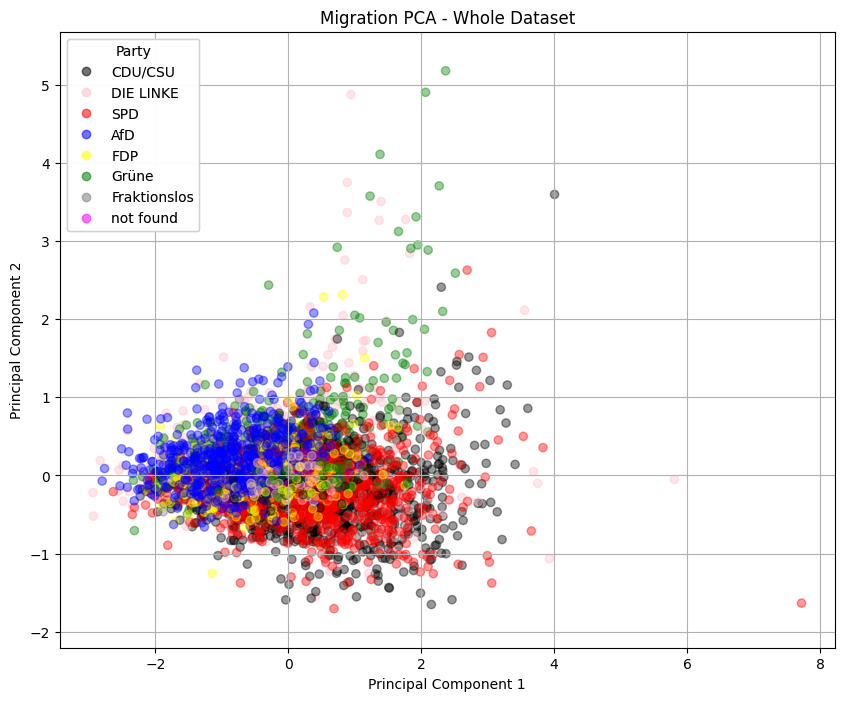

          high         low  pc
0       antrag         000   1
1        hilfe        gibt   1
2       gerade        ziel   1
3         zeit       krieg   1
4        union  angesichts   1
5      deshalb      glaube   1
6       nehmen   maßnahmen   1
7        reden     weniger   1
8     sprechen         gut   1
9  entwicklung      landes   1            high          low  pc
0      nationen   wirtschaft   2
1           oft         geht   2
2  angesprochen       wochen   2
3    ausbildung     haushalt   2
4   vergangenen           ja   2
5         leben         weiß   2
6         staat  flüchtlinge   2
7           tun       helfen   2
8        zahlen     deutsche   2
9        bisher       lassen   2


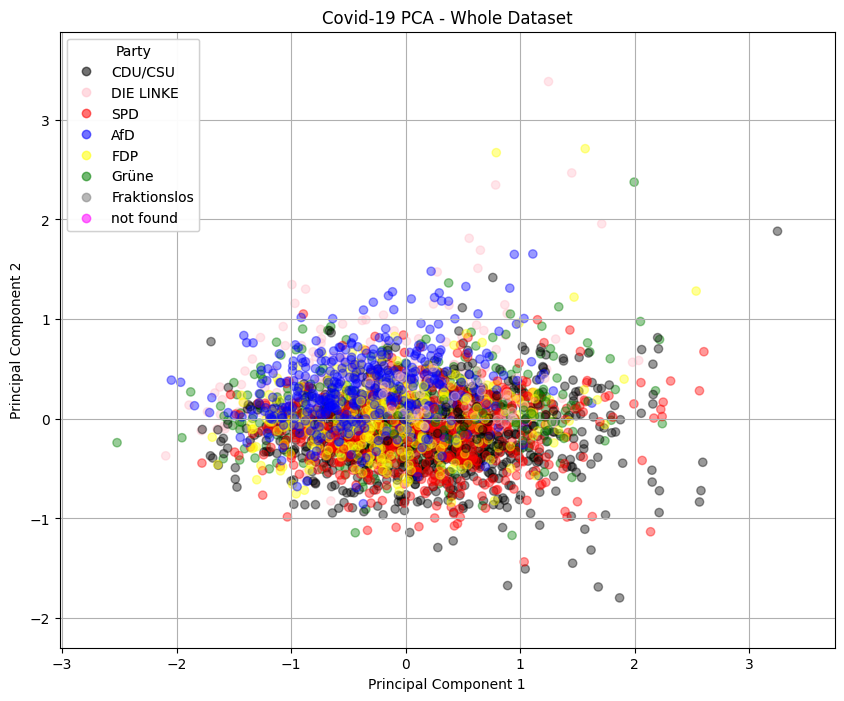

            high       low  pc
0           geld      bund   1
1          union  erhalten   1
2        möglich  covid-19   1
3      verfügung    folgen   1
4       familien  haushalt   1
5            wer     schon   1
6          darum    leider   1
7  investitionen  sozialen   1
8          steht     thema   1
9         gerade   bereich   1         high             low  pc
0       ziel           frage   2
1     bürger         aufgabe   2
2    soziale           danke   2
3   lockdown         bereich   2
4   beispiel          jahren   2
5      macht  entscheidungen   2
6        wer             000   2
7   pandemie          finden   2
8  koalition            welt   2
9  weiterhin            zwei   2


c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


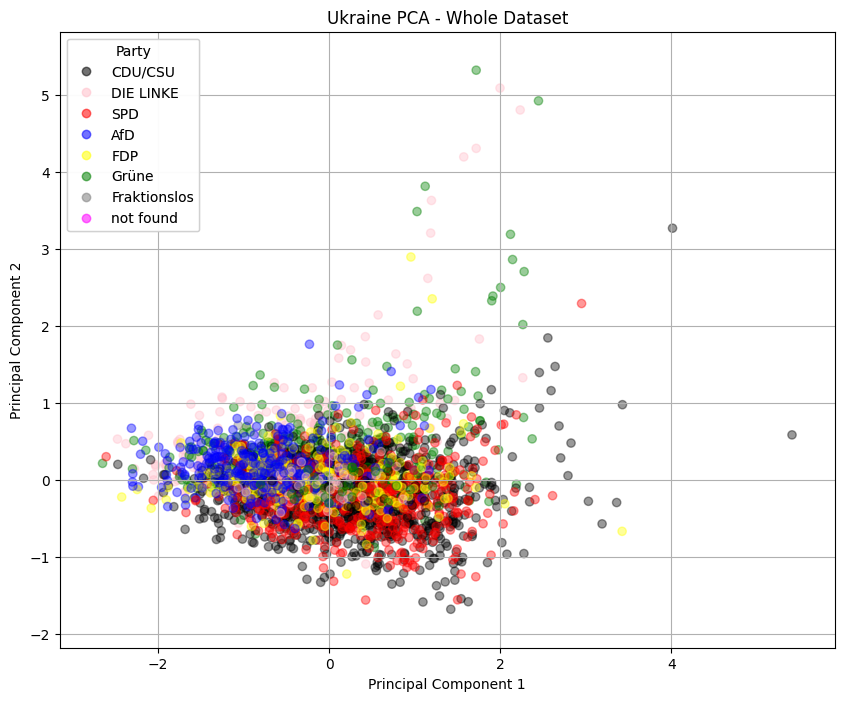

           high         low  pc
0       richtig       werte   1
1     russlands    russland   1
2     überhaupt   verehrten   1
3        führen  sanktionen   1
4        syrien     stellen   1
5         wurde     wichtig   1
6          seit   erreichen   1
7       ländern     bereits   1
8          zwei     prozent   1
9  europäischen       kommt   1               high            low  pc
0            wenig              “   2
1  bundesregierung  außenminister   2
2             ziel          gehen   2
3            krieg       nächsten   2
4      deutschland      millionen   2
5           türkei           darf   2
6           rahmen       kollegen   2
7        gegenüber            sei   2
8           müssen           sage   2
9        deutschen          rolle   2


In [36]:
#Migration

#The wide window was chosen as it was shown to work best on speech data in the original paper.
model = Doc2Vec(vector_size=300, window=20, min_count=50, workers=8, epochs=8)
appl_df = migration_speeches_all.copy()
apply_pca(appl_df)

mig_loads_1, mig_loads_2, org_part_mig, llm_part_mig, org_pol_mig, llm_pol_mig, llm_polpar_mig = run_pca(appl_df, "Migration PCA - Whole Dataset", "../pca_output/migration_all.png")
print(mig_loads_1, mig_loads_2)
#Covid
model = Doc2Vec(vector_size=300, window=20, min_count=50, workers=8, epochs=8)
appl_df = covid_speeches_all.copy()
apply_pca(appl_df)
cov_loads_1, cov_loads_2, org_part_cov, llm_part_cov, org_pol_cov, llm_pol_cov, llm_polpar_cov = run_pca(appl_df, "Covid-19 PCA - Whole Dataset", "../pca_output/covid_all.png")
print(cov_loads_1, cov_loads_2)

#Ukraine
model = Doc2Vec(vector_size=300, window=20, min_count=50, workers=8, epochs=8)
appl_df = ukraine_speeches_all.copy()
apply_pca(appl_df)
ukr_loads_1, ukr_loads_2, org_part_ukr, llm_part_ukr, org_pol_ukr, llm_pol_ukr, llm_polpar_ukr = run_pca(appl_df, "Ukraine PCA - Whole Dataset", "../pca_output/ukraine_all.png")
print(ukr_loads_1, ukr_loads_2)

In [23]:
# For an in-depth look, get a function to visualize the aggergated average positions.

def get_sum_vis(input_df, title, file_name, politician = None):

    abbreviation_colors = {
        'CDU/CSU': 'black',
        'DIE LINKE': 'pink',
        'SPD': 'red',
        'AfD': 'blue',
        'FDP': 'yellow',
        'Grüne': 'green',
        }
    
    input_df = input_df[(input_df["party"] != "not found") & (input_df["party"] != "Fraktionslos")]

    #ilter data for PC == 1 and PC == 2
    pc1_mean = input_df['mean'][input_df['pc'] == 1]
    pc2_mean = input_df['mean'][input_df['pc'] == 2]

    pc_party = input_df['party'][input_df['pc'] == 1]
    doc_type = input_df['doc_type'][input_df['pc'] == 1]                

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(pc1_mean, pc2_mean, c=[abbreviation_colors[party] for party in pc_party])
    plt.title(title)
    plt.xlabel('Mean for PC1')
    plt.ylabel('Mean for PC2')

    for i, txt in enumerate(doc_type):
        plt.annotate(txt, (pc1_mean.iloc[i], pc2_mean.iloc[i]), fontsize=8, ha='right', va='bottom')

    legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=party, linestyle='') for party, color in abbreviation_colors.items()]
    legend1 = plt.legend(handles=legend_elements, title="Party", loc='upper left')

    # Add legend to the plot
    plt.gca().add_artist(legend1)
    plt.grid(True)
    plt.savefig(file_name)
    plt.show()


### In-Depth View at Migation

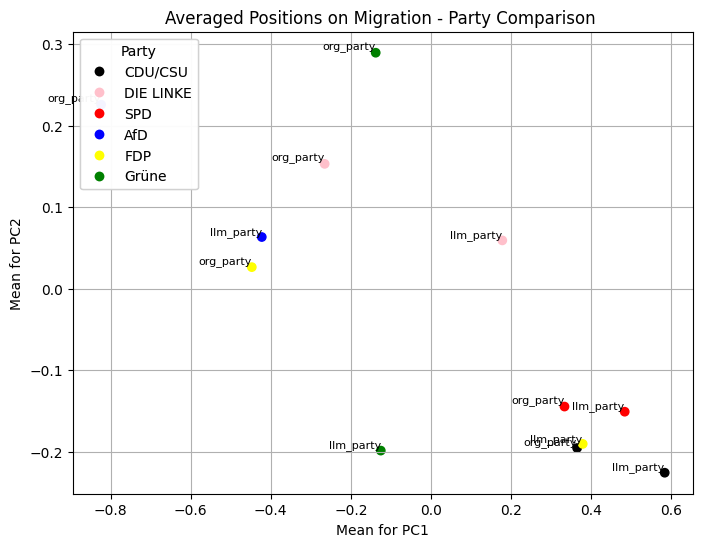

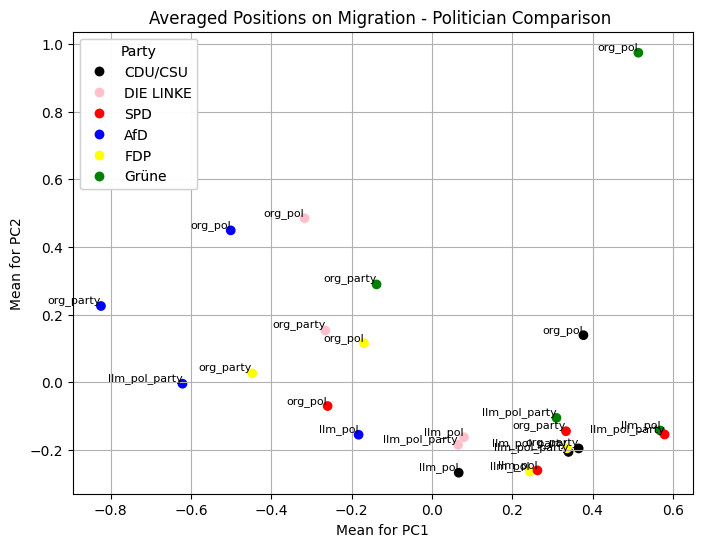

In [24]:
# # Data
# org_part_mig 
# org_part_mig["doc_type"] = "org_party"
# llm_part_mig
# org_pol_mig
# llm_pol_mig
# llm_polpar_mig
appl_df = pd.concat([org_part_mig, llm_part_mig])
get_sum_vis(appl_df, "Averaged Positions on Migration - Party Comparison ", "../pca_output/avg_mig_party.png")

#Compare Politician Aggregations

org_pol_mig_aggr = org_pol_mig.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
org_pol_mig_aggr = org_pol_mig_aggr.reset_index()

llm_pol_mig_aggr = llm_pol_mig.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_pol_mig_aggr = llm_pol_mig_aggr.reset_index()

llm_polpar_mig_aggr = llm_polpar_mig.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_polpar_mig_aggr = llm_polpar_mig_aggr.reset_index()

appl_df = pd.concat([org_part_mig, org_pol_mig_aggr, llm_pol_mig_aggr, llm_polpar_mig_aggr])
get_sum_vis(appl_df, "Averaged Positions on Migration - Politician Comparison ", "../pca_output/avg_mig_pol.png")

### In-Depth Vew at Covid

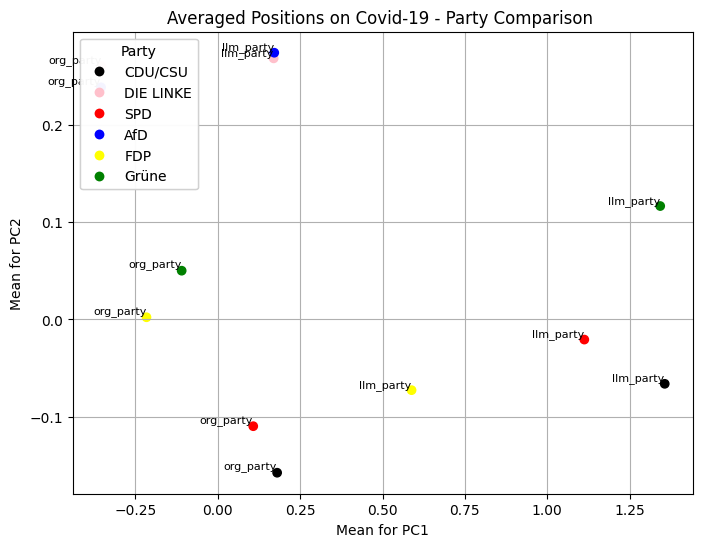

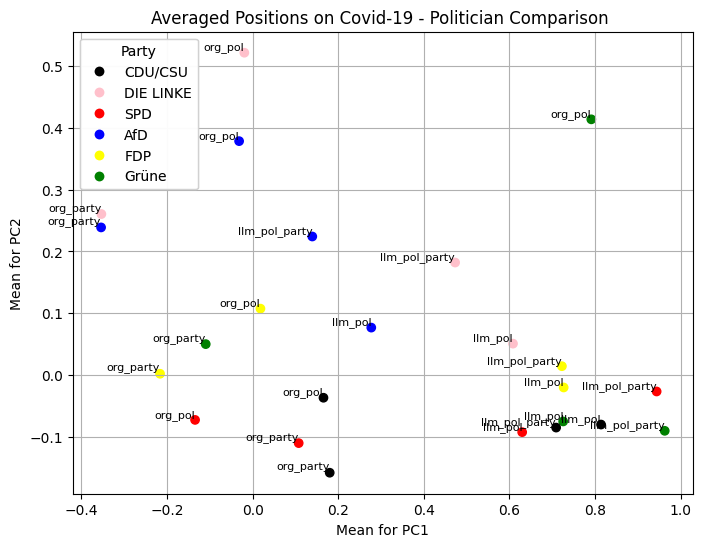

In [25]:
appl_df = pd.concat([org_part_cov, llm_part_cov])
get_sum_vis(appl_df, "Averaged Positions on Covid-19 - Party Comparison ", "../pca_output/avg_cov_party.png")

#Compare Politician Aggregations

org_pol_cov_aggr = org_pol_cov.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
org_pol_cov_aggr = org_pol_cov_aggr.reset_index()

llm_pol_cov_aggr = llm_pol_cov.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_pol_cov_aggr = llm_pol_cov_aggr.reset_index()

llm_polpar_cov_aggr = llm_polpar_cov.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_polpar_cov_aggr = llm_polpar_cov_aggr.reset_index()

appl_df = pd.concat([org_part_cov, org_pol_cov_aggr, llm_pol_cov_aggr, llm_polpar_cov_aggr])
get_sum_vis(appl_df, "Averaged Positions on Covid-19 - Politician Comparison ", "../pca_output/avg_cov_pol.png")

### In-Depth View at the War in Ukraine

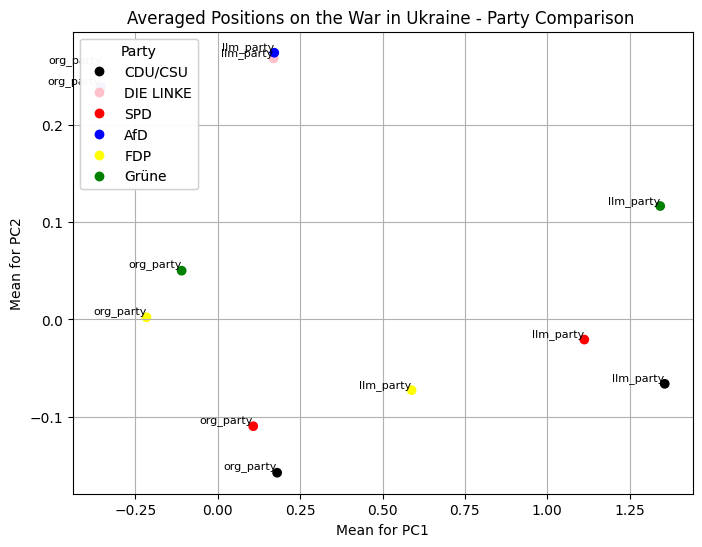

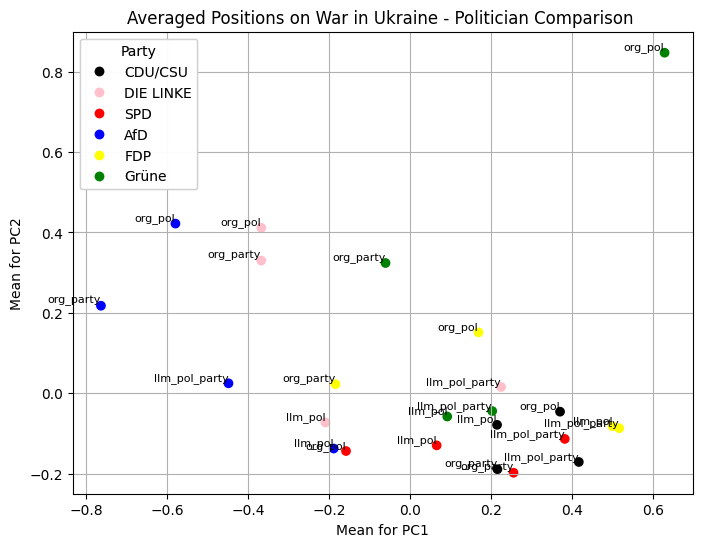

In [26]:
appl_df = pd.concat([org_part_cov, llm_part_cov])
get_sum_vis(appl_df, "Averaged Positions on the War in Ukraine - Party Comparison ", "../pca_output/avg_ukr_party.png")

#Compare Politician Aggregations

org_pol_ukr_aggr = org_pol_ukr.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
org_pol_ukr_aggr = org_pol_ukr_aggr.reset_index()

llm_pol_ukr_aggr = llm_pol_ukr.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_pol_ukr_aggr = llm_pol_ukr_aggr.reset_index()

llm_polpar_ukr_aggr = llm_polpar_ukr.groupby(['party', 'pc', 'doc_type'])[['mean', 'median']].mean()
llm_polpar_ukr_aggr = llm_polpar_ukr_aggr.reset_index()

appl_df = pd.concat([org_part_ukr, org_pol_ukr_aggr, llm_pol_ukr_aggr, llm_polpar_ukr_aggr])
get_sum_vis(appl_df, "Averaged Positions on War in Ukraine - Politician Comparison ", "../pca_output/avg_ukr_pol.png")

### In-Depth Look at Individual Politicians

Can't look through this much qualitatively, just some for investigation

In [27]:
in_depth_mig = pd.concat([org_pol_mig, llm_polpar_mig, llm_pol_mig])
in_depth_cov = pd.concat([org_pol_cov, llm_polpar_cov, llm_pol_cov])
in_depth_ukr = pd.concat([org_pol_ukr, llm_polpar_ukr, llm_pol_ukr])

abaer =  in_depth_ukr[in_depth_mig["politician"] == "Annalena Baerbock"]
agaul = in_depth_cov[in_depth_cov["politician"] == "Alexander Gauland"]	
pamt = in_depth_mig[in_depth_ukr["politician"] == "Philipp Amthor"]	


In [28]:
abaer

# all very far apart

,pc,politician,party,mean,median,doc_type
42,1,Annalena Baerbock,Grüne,0.334054,0.535539,org_pol
43,2,Annalena Baerbock,Grüne,0.283757,0.321135,org_pol
42,1,Annalena Baerbock,Grüne,0.499451,0.414589,llm_pol_party
43,2,Annalena Baerbock,Grüne,-0.078851,-0.140002,llm_pol_party
42,1,Annalena Baerbock,Grüne,0.003182,-0.009186,llm_pol
43,2,Annalena Baerbock,Grüne,0.018953,0.003907,llm_pol


In [29]:
agaul

# all very far apart too

,pc,politician,party,mean,median,doc_type
0,1,Alexander Gauland,AfD,-0.438675,-0.538945,org_pol
1,2,Alexander Gauland,AfD,0.331170,0.398960,org_pol
0,1,Alexander Gauland,AfD,-0.110382,-0.224971,llm_pol_party
1,2,Alexander Gauland,AfD,0.302106,0.376935,llm_pol_party
0,1,Alexander Gauland,AfD,0.429672,0.334205,llm_pol
1,2,Alexander Gauland,AfD,0.192558,0.257742,llm_pol


In [30]:
pamt

#this is  quite good give the axis dimensions

,pc,politician,party,mean,median,doc_type
20,1,Philipp Amthor,CDU/CSU,0.020256,-0.098073,org_pol
21,2,Philipp Amthor,CDU/CSU,0.186120,0.176364,org_pol
20,1,Philipp Amthor,CDU/CSU,0.160423,0.095221,llm_pol_party
21,2,Philipp Amthor,CDU/CSU,-0.263528,-0.200324,llm_pol_party
20,1,Philipp Amthor,CDU/CSU,-0.074459,-0.172098,llm_pol
21,2,Philipp Amthor,CDU/CSU,-0.190930,-0.198468,llm_pol


### Euclidean Distance

In [31]:
# do it quantitatively: average total distance

def get_euc_dist(input_df, variable, doc_type_1, doc_type_2, text_bit):
    
#    input_df['mean'] = (input_df['mean'] - input_df['mean'].min()) / (df['mean'].max() - df['mean'].min())
    euc_dists = []
    for instance in input_df[variable].unique():
        if instance != "Fraktionslos":
            sub_df = input_df[input_df[variable] == instance]    
            pc1_df = sub_df[sub_df['pc'] == 1]
            pc2_df = sub_df[sub_df['pc'] == 2]

            # Extract mean values for org_pol and llm_pol
            pc1_org = pc1_df.loc[pc1_df['doc_type'] == doc_type_1, 'mean'].iloc[0]
            pc1_llm = pc1_df.loc[pc1_df['doc_type'].str.contains(doc_type_2), 'mean'].mean()
            pc2_org = pc2_df.loc[pc2_df['doc_type'] == doc_type_1, 'mean'].iloc[0]
            pc2_llm = pc2_df.loc[pc2_df['doc_type'].str.contains(doc_type_2), 'mean'].mean()

            # Calculate Euclidean distance between mean values for pc 1 and pc 2
            euc_dist = ((pc1_org - pc1_llm) ** 2 + (pc2_org - pc2_llm) ** 2) ** 0.5
            euc_dists.append(euc_dist)
        
    avg_euc_dist = euc_dist.mean()
    
    print(f"The average euclidean distance between {text_bit} is:", avg_euc_dist)
    
#    return avg_euc_dist


In [32]:
#parties
appl_df = pd.concat([org_part_ukr, llm_part_ukr])
get_euc_dist(appl_df, "party", "org_party", "llm_party", "parties for the topic of the Ukraine war")

appl_df = pd.concat([org_part_cov, llm_part_cov])
get_euc_dist(appl_df, "party", "org_party", "llm_party", "parties for the topic of the Covid-19 pandemic")

appl_df = pd.concat([org_part_mig, llm_part_mig])
get_euc_dist(appl_df, "party", "org_party", "llm_party", "parties for the topic of migration")

#politicians and politicians without party context
appl_df = pd.concat([org_pol_ukr, llm_pol_ukr])
get_euc_dist(appl_df, "politician", "org_pol", "llm_pol", "politicians and artificial politicians without party context for the topic of the Ukraine war")

appl_df = pd.concat([org_pol_cov, llm_pol_cov])
get_euc_dist(appl_df, "politician", "org_pol", "llm_pol", "politicians and artificial politicians without party context for the topic of the Covid-19 pandemic")

appl_df = pd.concat([org_pol_mig, llm_pol_mig])
get_euc_dist(appl_df, "politician", "org_pol", "llm_pol", "politicians and artificial politicians without party context for the topic of migration")

#politicians and politicians with party context
appl_df = pd.concat([org_pol_ukr, llm_polpar_ukr])
get_euc_dist(appl_df, "politician", "org_pol", "llm_pol_party", "politicians and artificial politicians with party context for the topic of the Ukraine war")

appl_df = pd.concat([org_pol_cov, llm_polpar_cov])
get_euc_dist(appl_df, "politician", "org_pol", "llm_pol_party", "politicians and artificial politicians with party context for the topic of the Covid-19 pandemic")

appl_df = pd.concat([org_pol_mig, llm_polpar_mig])
get_euc_dist(appl_df, "politician", "org_pol", "llm_pol_party", "politicians and artificial politicians with party context for the topic of migration")

#org_part_ukr, llm_part_ukr, org_pol_ukr, llm_pol_ukr, llm_polpar_ukr


The average euclidean distance between parties for the topic of the Ukraine war is: 0.382885048314755
The average euclidean distance between parties for the topic of the Covid-19 pandemic is: 0.5267243931485325
The average euclidean distance between parties for the topic of migration is: 0.43301944108604645
The average euclidean distance between politicians and artificial politicians without party context for the topic of the Ukraine war is: 0.2774884173937432
The average euclidean distance between politicians and artificial politicians without party context for the topic of the Covid-19 pandemic is: 0.8583555455243109
The average euclidean distance between politicians and artificial politicians without party context for the topic of migration is: 0.6253259736390795
The average euclidean distance between politicians and artificial politicians with party context for the topic of the Ukraine war is: 0.2727196057339759
The average euclidean distance between politicians and artificial poli

In [33]:
llm_polpar_ukr


,pc,politician,party,mean,median,doc_type
0,1,Alexander Gauland,AfD,-0.264193,-0.249392,llm_pol_party
1,2,Alexander Gauland,AfD,-0.072174,-0.002132,llm_pol_party
2,1,Peter Boehringer,AfD,-0.463180,-0.406841,llm_pol_party
3,2,Peter Boehringer,AfD,0.175897,0.198687,llm_pol_party
4,1,Norbert Kleinwächter,AfD,-0.437963,-0.389746,llm_pol_party
5,2,Norbert Kleinwächter,AfD,0.012759,-0.018834,llm_pol_party
6,1,Götz Frömming,AfD,-0.631379,-0.588286,llm_pol_party
7,2,Götz Frömming,AfD,-0.017445,0.069039,llm_pol_party
8,1,Rolf Mützenich,SPD,0.436870,0.469835,llm_pol_party
9,2,Rolf Mützenich,SPD,-0.089687,-0.103389,llm_pol_party


### Case 2: Politician and Politician/Party Positions

Get the PCA for all original speeches and politicians by topic in subset of politicians. This is to have a qualitative look at what the distribution would look like in the subset. Arguably, this subset is too small for Doc2Vec. Hence, we did not include it in the report. It shows that the differnces between parties are seemingly less prominent, which makes sense with a smaller population.

c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


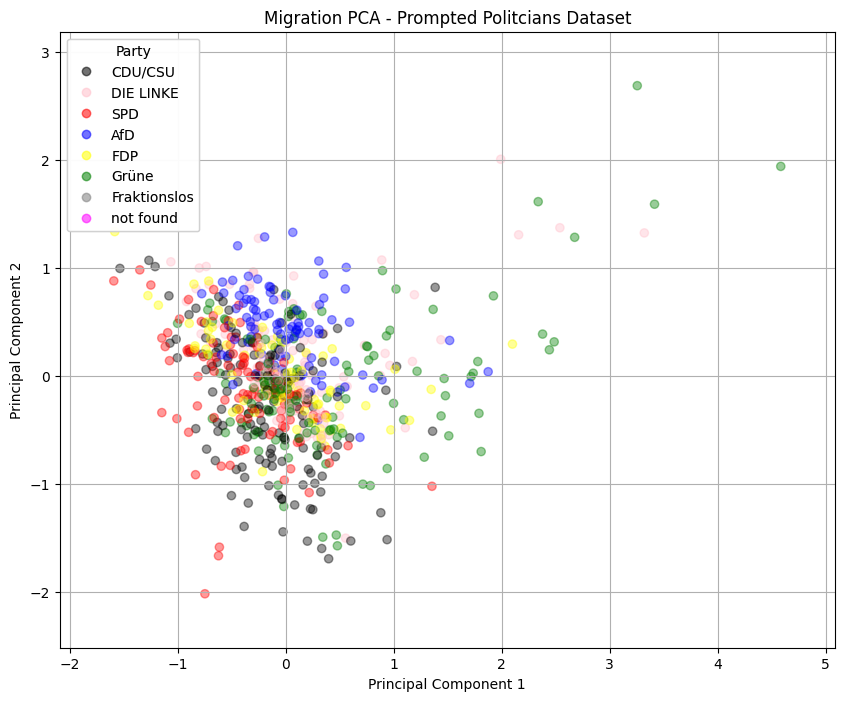

        high           low  pc
0     schutz       bildung   1
1      denen      wirklich   1
2  regierung  gleichzeitig   1
3     worden           gar   1
4    stellen         immer   1
5    endlich   kolleginnen   1
6  natürlich       wichtig   1
7      macht          geld   1
8     vielen     millionen   1
9       land        müssen   1           high      low  pc
0    deutschen     seit   2
1        leben  prozent   2
2      darüber     dank   2
3  kolleginnen    denen   2
4         geht  grenzen   2
5        liegt  aufgabe   2
6       sorgen  letzten   2
7    migration    genau   2
8       kommen    immer   2
9        heißt   schutz   2


c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


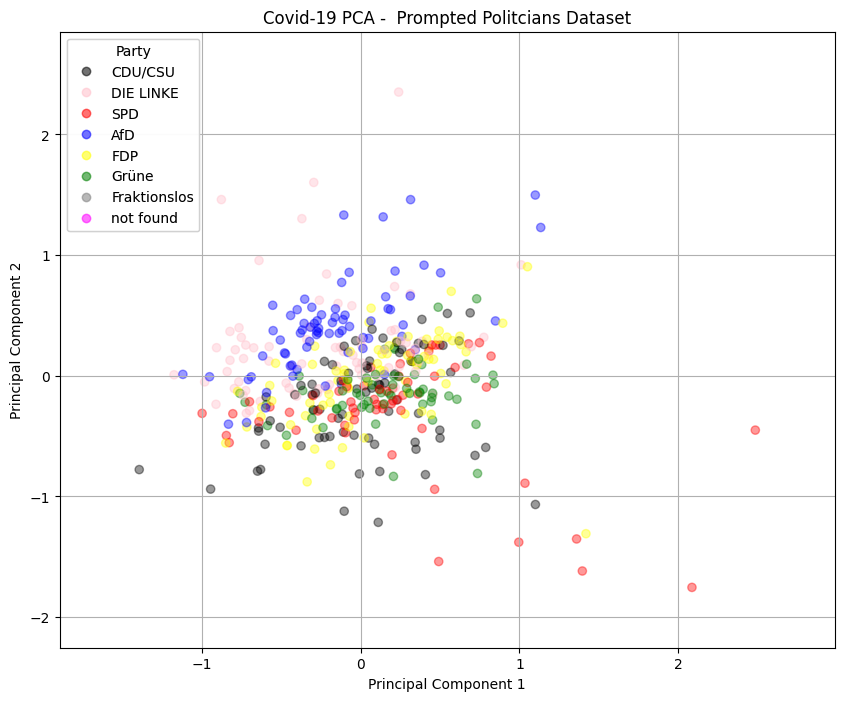

             high           low  pc
0          europa        stelle   1
1  entscheidungen       fordern   1
2           geben        stehen   1
3    insbesondere     bundestag   1
4               „       bereits   1
5         gezeigt  gesellschaft   1
6           macht          geld   1
7        arbeiten     vertrauen   1
8           große      covid-19   1
9          möchte          geht   1            high                low  pc
0  gesellschaft       insbesondere   2
1     notwendig             wissen   2
2          erst                  „   2
3         immer               eben   2
4      pandemie             jahren   2
5      wirklich       öffentlichen   2
6          geld              warum   2
7         krise           nächsten   2
8         leben  herausforderungen   2
9       einfach               rede   2


c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elias\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


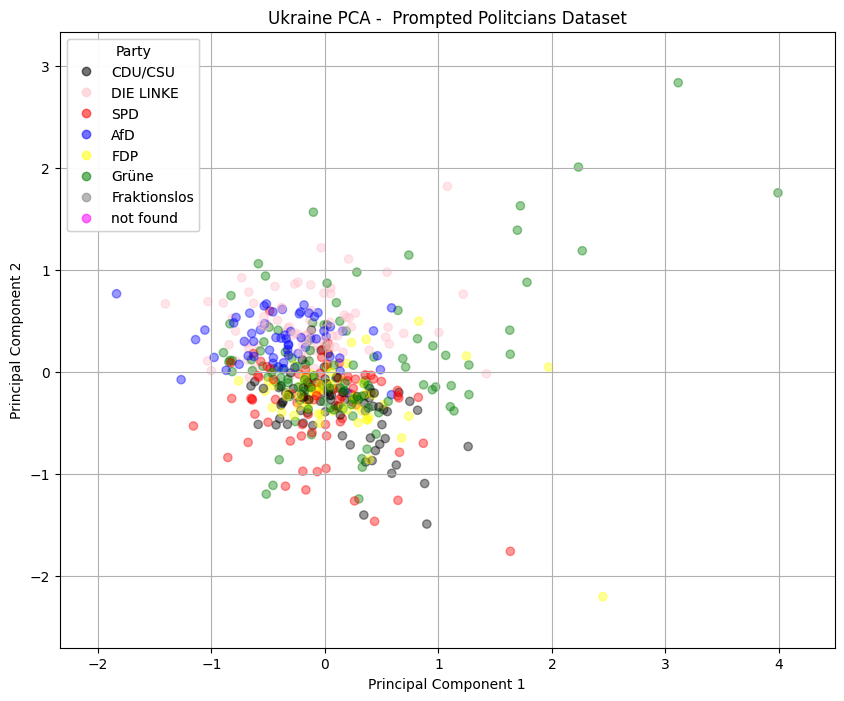

            high        low  pc
0       kollegen       gilt   1
1       sprechen  bundestag   1
2           herr     länder   1
3          steht    antwort   1
4       menschen     setzen   1
5              „      davon   1
6     sanktionen  situation   1
7          seite    nämlich   1
8          damen   bedeutet   1
9  unterstützung  russische   1             high              low  pc
0         kommen         deutsche   2
1          seite        vergessen   2
2  verantwortung           setzen   2
3          thema          bleiben   2
4         waffen            krise   2
5           gilt             klar   2
6         leider      solidarität   2
7          dafür  bundeskanzlerin   2
8      gemeinsam       diplomatie   2
9       kollegen  internationalen   2


In [34]:
pol_names = politician_df['name'].tolist()

covid_speeches_pols = covid_speeches_all[covid_speeches_all['full_name'].isin(pol_names)]
ukraine_speeches_pols = ukraine_speeches_all[ukraine_speeches_all['full_name'].isin(pol_names)]
migration_speeches_pols = migration_speeches_all[migration_speeches_all['full_name'].isin(pol_names)]

#Migration
model = Doc2Vec(vector_size=200, window=30, min_count=40, workers=8, epochs=8)
appl_df = migration_speeches_pols.copy()
apply_pca(appl_df)

mig_loads_1_sub, mig_loads_2_sub, org_part_mig_sub, llm_part_mig_sub, org_pol_mig_sub, llm_pol_mig_sub, llm_polpar_mig_sub = run_pca(appl_df, "Migration PCA - Prompted Politcians Dataset", "../pca_output/migration_pols.png")
print(mig_loads_1_sub, mig_loads_2_sub)

#Covid
model = Doc2Vec(vector_size=200, window=30, min_count=40, workers=8, epochs=8)

appl_df = covid_speeches_pols.copy()
apply_pca(appl_df)
cov_loads_1_sub, cov_loads_2_sub, org_part_cov_sub, llm_part_cov_sub, org_pol_cov_sub, llm_pol_cov_sub, llm_polpar_cov_sub = run_pca(appl_df, "Covid-19 PCA -  Prompted Politcians Dataset", "../pca_output/covid_pols.png")
print(cov_loads_1_sub, cov_loads_2_sub)

# #Ukraine
model = Doc2Vec(vector_size=200, window=30, min_count=40, workers=8, epochs=8)

appl_df = ukraine_speeches_pols.copy()
apply_pca(appl_df)
ukr_loads_1_sub, ukr_loads_2_sub, org_part_ukr_sub, llm_part_ukr_sub, org_pol_ukr_sub, llm_pol_ukr_sub, llm_polpar_ukr_sub = run_pca(appl_df, "Ukraine PCA -  Prompted Politcians Dataset", "../pca_output/ukraine_pols.png")
print(ukr_loads_1_sub, ukr_loads_2_sub)
